## Reactive Covariance - Project in Python 

### I - Leverage Effect in Financial Markets (Paper 1) 


In [1]:
# Import relevant libraries

import matplotlib.pyplot as plt
import pandas as pd
import os
import fnmatch
import random
import scipy as sp
from scipy.optimize import curve_fit
import numpy as np

In [35]:
## Creer un dictionnaire a partir de CSV

index_df = pd.read_excel('Data\indices.xls') # importer l'Excel de prix 
index_dictionnary = {"Ticker1" : "STOXX 600", "Ticker2":"STOXX 50","Ticker3" : "S&P 500", "Ticker4" : "TOPIX", "Ticker5": "FTSE", "Ticker6":"DAX", "Ticker7":"NIKKEI","Ticker8":"NASDAQ"}
index_df.head()

,STOXX 600,STOXX 50,S&P 500,TOPIX,FTSE,DAX,NIKKEI,NASDAQ
1990-01-01,108.16,1098.49,353.40,2881.37,2422.7,1778.119995,38915.87109,454.82
1990-01-02,108.63,1101.34,359.69,2881.37,2434.1,1788.890015,38915.87109,459.33
1990-01-03,110.04,1112.82,358.76,2881.37,2463.7,1867.290039,38915.87109,460.90
1990-01-04,110.02,1113.02,355.67,2867.70,2451.6,1830.920044,38712.87891,459.39
1990-01-05,109.02,1099.52,352.20,2834.61,2444.5,1812.900024,38274.76172,458.22


In [33]:
for key in index_dictionnary:
    Ticker = index_dictionnary.get(key)
    df = pd.read_excel('Data\indices.xls')
    df = df[Ticker]


In [12]:
## Le but de cette classe est de regrouper les méthodes permettant le calcul du leverage
## L'idée est ensuite de pouvoir calculer rapidement le leverage en loopant sur des centaines de stocks et indices 

class ComputeLeverage: 
    
    def __init__(self): ## Méthode du constructeur
        self.ticker = Ticker ## on construit l'objet prenant comme parametre le ticker du stock
        self.df = pd.read_excel('Data\indices.xls')
        #self.df = self.df[Ticker]
        self.tau = Tau
        # On importe les données dans la construction de l'objet. La dataframe "df" sera utilisee par les autres méthodes de la classe
    
    def deltaTau(self,tau): # Cette fonction calcule la variation du prix entre t et t + tau (delta x(t+tau)) 
        return ((self.df[Ticker].shift(-tau) - self.df[Ticker].shift(-tau+1))/self.df[Ticker].shift(-tau+1))
    
    def zHat(self,tau,T): # Cette fonction calcule Z chapeau
        self.df["Interm_Z"] = (self.deltaTau(0)**2)  # Calcule l'intérieur de la somme 
        return ((1/(T-1))*(self.df["Interm_Z"].sum()))**2 # Retourne la somme des carrés normalisé par T
        
    def lHat(self,tau,T): 
        self.df["Interm_Prod_Delta"]  = ((self.deltaTau(tau))**2)*self.deltaTau(0)  # Check if 0 or 1 
        return (1/self.zHat(tau,T))*(self.df["Interm_Prod_Delta"].sum())/((T-tau)) # Divisé par T ou T - Tau ?
    
    def PlotLeverage(self):
        T = self.df.shape[0] # size of our sample
        result_df = pd.DataFrame([])
        for tau in range(0,200): ## specify the max range for the time horizon 
             result_df = result_df.append(pd.DataFrame({"Tau":tau,'L_Hat': self.lHat(tau,T)}, index=[0]), ignore_index=True)
                
        return result_df.plot.scatter(x = "Tau", y = "L_Hat" )
    
    ## C'est exactement la même méthode qu'au dessus. La seule différence est qu'elle retourne le résultat sous forme de tableau et non de graph
    def ReturnLeverage(self):
        T = self.df.shape[0] # size of our sample
        result_df = pd.DataFrame([])
        for tau in range(1,self.tau): ## specify the max range for the time horizon 
            result_df = result_df.append(pd.DataFrame({"Tau":tau,self.ticker: self.lHat(tau,T)}, index=[0]), ignore_index=True)
        return result_df

In [24]:
Tau = 200  ## On spécifie ici l'horizon de temps qui sera calculé au sein de la classe 

leverage_df = pd.DataFrame({"Tau":range(1,Tau)}) # Création de la première colonne comportant les valeurs de Tau

for key in index_dictionnary:
    Ticker = index_dictionnary.get(key) ## définition du ticker pour la création de l'objet
    myStock = ComputeLeverage() ## Creation de l'objet 
    leverage_df = pd.concat([leverage_df,myStock.ReturnLeverage()[Ticker]], axis=1) # Concaténation du leverage pour chaque stock dans la dataframe Leverage_df

print(leverage_df)

     Tau  STOXX 600   STOXX 50    S&P 500      TOPIX       FTSE        DAX  \
0      1 -28.370510 -22.344797 -31.776935 -18.106882 -21.152076 -17.675235   
1      2 -19.976781 -13.404320 -28.513623 -23.078525 -18.475387 -12.494372   
2      3 -29.818443 -20.229991 -17.285914 -15.960970 -28.158242 -17.495733   
3      4 -18.789958 -13.793239 -25.554852 -22.212422 -14.347965 -15.495401   
4      5 -21.746604 -15.566872 -21.235866  -9.930559 -19.640948  -9.862291   
5      6  -7.242282  -3.767413  -5.004332 -13.146847 -10.131586  -3.747626   
6      7 -12.113918  -7.684583  -9.208798 -13.626596 -14.143810  -5.597536   
7      8 -16.373165 -11.740627 -20.887378 -13.749472 -10.824842  -9.798451   
8      9 -18.553294 -14.623981 -13.515712  -3.040433 -20.104154 -15.300214   
9     10 -20.379428  -9.992938 -22.801192 -18.085851 -19.737801  -8.185892   
10    11  -5.542992  -4.264689  -0.941269  -4.734748   0.900852  -1.094884   
11    12 -15.735704 -13.356544  -7.807460  -3.067428 -14.491680 

     Tau  Mean Leverage
0      1     -21.610769
1      2     -20.016301
2      3     -19.324985
3      4     -17.510214
4      5     -15.358658
5      6      -8.177682
6      7      -8.984267
7      8     -12.174721
8      9     -12.983590
9     10     -16.112498
10    11      -3.291499
11    12     -10.162052
12    13      -9.623859
13    14      -7.312807
14    15     -10.433951
15    16       1.642289
16    17      -7.221093
17    18      -5.888928
18    19      -6.820304
19    20      -9.330011
20    21     -11.769747
21    22      -6.551313
22    23      -8.234657
23    24      -1.008271
24    25      -3.202685
25    26      -5.371040
26    27      -5.337232
27    28      -5.895778
28    29      -6.192488
29    30       0.493344
..   ...            ...
169  170      -2.890942
170  171       3.652734
171  172      -1.551366
172  173       0.194395
173  174      -0.127955
174  175       0.169334
175  176       1.311005
176  177       2.563130
177  178      -0.419510
178  179      -0

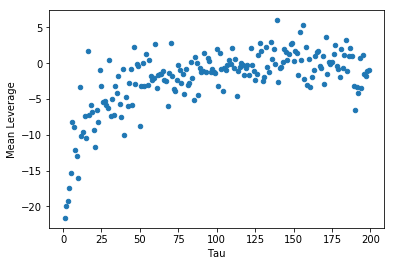

In [27]:
# On cree une colonne qui prend la moyenne du leverage pour tous les stocks pour chaque maturité Tau
mean_leverage_df = pd.DataFrame({"Tau":range(1,Tau)}) # Création de la première colonne comportant les valeurs de Tau
mean_leverage_df["Mean Leverage"] = leverage_df.drop(["Tau"],axis=1).mean(axis=1) # Ne pas oublier de moyenner en enlevant la colonne Tau!

#mean_leverage_df = mean_leverage_df[mean_leverage_df["Mean Leverage"]< 4] # Filtre pour enlever les outliers 
#mean_leverage_df = mean_leverage_df[mean_leverage_df["Mean Leverage"]> -4] # Filtre pour enlever les outliers 

print(mean_leverage_df)
mean_leverage_df.plot.scatter(x = "Tau", y = "Mean Leverage" ) # Plot pour voir le résultat 

#axes = plt.gca() # Means Get the Current Axes 
#axes.set_ylim([-8.0,6.0]) # This methods enables to change the axes on a subplot


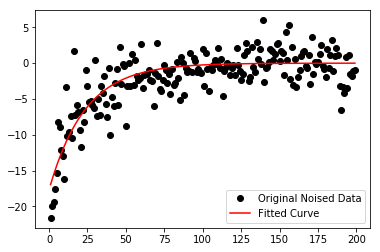

array([-17.70587529,  23.41066502])

In [34]:
def func(x, a, b):
  return a * np.exp(-x/b) 

x= mean_leverage_df["Tau"]
y= mean_leverage_df["Mean Leverage"]

popt, pcov = curve_fit(func, x, y, p0 = (-18,10))

plt.figure()
plt.plot(x, y, 'ko', label="Original Noised Data")
plt.plot(x, func(x, *popt), 'r-', label="Fitted Curve")
#plt.ylim(-10,10)
plt.legend()
plt.show()
popt